# Árvores II - Tarefa 2

### 1. Carregar as bases

Vamos carregar as bases lidas na tarefa passada. Se você salvou essas bases em arquivo texto, basta fazer a leitura com o comando ```pd.read_csv``` das seguintes bases:

- X_train
- Y_train
- X_test
- Y_test

Não se esqueça de considerar a leitura dos índices dos arquivos no ```read_csv()```!

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay



### 2. Divisão da base em Treino, Validação e Teste

A base já se encontra dividida em Treino e Validação. O que vamos fazer então é extrair uma base de Validação da base de Treino.

Extraia 25% da base de treino como base de validação.

In [8]:
X_train = pd.read_csv('/content/X_train.txt', delim_whitespace=True, header=None)
X_test = pd.read_csv('/content/X_test.txt', delim_whitespace=True, header=None)
y_train = pd.read_csv('/content/y_train.txt', header=None)
y_test = pd.read_csv('/content/y_test.txt', header=None)

<ipython-input-8-e07742e0b036>:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  X_train = pd.read_csv('/content/X_train.txt', delim_whitespace=True, header=None)
<ipython-input-8-e07742e0b036>:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  X_test = pd.read_csv('/content/X_test.txt', delim_whitespace=True, header=None)


In [9]:
# Divisão: 75% treino, 25% validação
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=42
)


In [10]:
print(X_val.shape)
print(y_val.shape)
print(X_train_final.shape)
print(y_train_final.shape)

(1838, 561)
(1838, 1)
(5514, 561)
(5514, 1)


In [11]:
proporcao_val = len(X_val) / (len(X_val) + len(X_train_final))
print(f"Proporção da base de validação: {proporcao_val:.2%}")


Proporção da base de validação: 25.00%


### 3. Melhores 3 variáveis

Rode uma árvore com profundidade máxima igual a 4 para prever a atividade humana com todas as variáveis.
Observe a importância das variáveis e considere as 3 variáveis com maior importância para os próximos passos.
Dica: utilize o atributo ```clf.feature_importances_``` da árvore treinada.

In [12]:
# Treinar a árvore com profundidade máxima = 4
clf = DecisionTreeClassifier(max_depth=4, random_state=42)
clf.fit(X_train_final, y_train_final.values.ravel())  # ravel() para transformar em vetor 1D

# Coletar as importâncias das variáveis
importancias = clf.feature_importances_

# Cria um DataFrame com nomes e importâncias (usando posições como nomes se não houver colunas nomeadas)
df_importancias = pd.DataFrame({
    'variavel': X_train_final.columns,
    'importancia': importancias
})

# Ordena pelas mais importantes
top_variaveis = df_importancias.sort_values(by='importancia', ascending=False).head(3)
print(top_variaveis)


     variavel  importancia
52         52     0.285303
389       389     0.254091
41         41     0.164608


### 4. Construa uma árvore com as 3 melhores variáveis

Utilizando as três variáveis encontradas acima, construa uma árvore de decisão. Encontre o melhor ```ccp_alpha``` utilizando a base de validação, conforme a estrutura que vimos em aula.

In [13]:
%%time

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import numpy as np

# Suponha que top_variaveis tenha sido definido anteriormente
top3_indices = top_variaveis['variavel'].values

# Seleciona só as 3 melhores variáveis
X_train_top3 = X_train_final[top3_indices]
X_val_top3 = X_val[top3_indices]

# Árvore inicial para obter ccp_alphas possíveis
clf = DecisionTreeClassifier(random_state=42)
path = clf.cost_complexity_pruning_path(X_train_top3, y_train_final)
ccp_alphas = path.ccp_alphas

# Treinar uma árvore para cada alpha
modelos = []
valid_scores = []

for alpha in ccp_alphas:
    clf_alpha = DecisionTreeClassifier(random_state=42, ccp_alpha=alpha)
    clf_alpha.fit(X_train_top3, y_train_final)
    y_val_pred = clf_alpha.predict(X_val_top3)
    acc = accuracy_score(y_val, y_val_pred)
    modelos.append(clf_alpha)
    valid_scores.append(acc)

# Encontra o melhor alpha
melhor_alpha = ccp_alphas[np.argmax(valid_scores)]
print("Melhor ccp_alpha:", melhor_alpha)

# Treina árvore final com o melhor alpha
arvore_final = DecisionTreeClassifier(random_state=42, ccp_alpha=melhor_alpha)
arvore_final.fit(X_train_top3, y_train_final)

# Acurácia final na validação
acc_final = accuracy_score(y_val, arvore_final.predict(X_val_top3))
print("Acurácia final na validação:", acc_final)



Melhor ccp_alpha: 0.0002747826469262813
Acurácia final na validação: 0.8933623503808488
CPU times: user 9.12 s, sys: 28.5 ms, total: 9.15 s
Wall time: 12 s


### 5. Avaliação do modelo

Avalie a árvore encontrada no item anterior na base de testes.

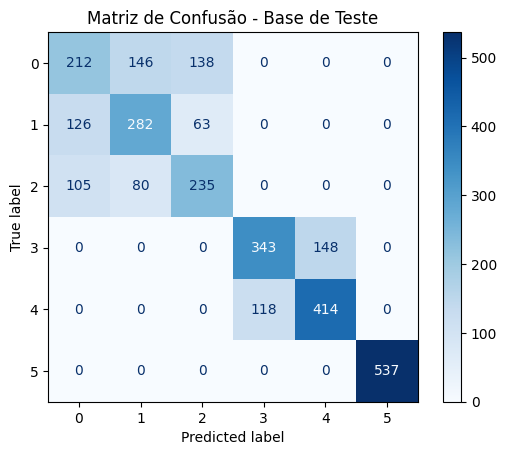

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Calcula a matriz de confusão
cm = confusion_matrix(y_test, y_test_pred)

# Exibe a matriz
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', values_format='d')
plt.title("Matriz de Confusão - Base de Teste")
plt.show()

In [19]:
# Seleciona as mesmas 3 variáveis no conjunto de teste
X_test_top3 = X_test[top3_indices]

# Predição na base de teste
y_test_pred = arvore_final.predict(X_test_top3)

# Acurácia
acc_teste = accuracy_score(y_test, y_test_pred)
print(f"Acurácia na base de teste: {acc_teste:.2%}")

Acurácia na base de teste: 68.65%
